# The PyTorch JIT
## PyCon 2019 - Berlin
### Tilman Krokotsch

# About Me

### Tilman Krokotsch
#### Deep Learning Engineer @ IAV GmbH automotive engineering
#### PhD Student @ TU Berlin under Prof. Clemens Gühmann

First of all, we have to explain what a JIT is. The Acronym stands for Just-In-Time compiler. It compiles source code to machine code during runtime. This way the code can be serialized for easy transfer and optimized for faster execution. In our case, the JIT can compile a subset of the Python language, called TorchScript, to a computation graph. This graph can then be executed just as you would with a TensorFlow graph.

# What are we talking about?

### JIT == Just-in-time compiler

> \[..\] is a way to create serializable and optimizable models from PyTorch code. _**- PyTorch Docs**_

### Examples
* Java Virtual Machine (JVM)
* PHP 8 in 2021 \[[Source](https://hub.packtpub.com/php-8-and-7-4-to-come-with-just-in-time-jit-to-make-most-cpu-intensive-workloads-run-significantly-faster/)\]

These are the promises I made in the title of this talk. They are based on my understanding of the JIT at the time of writing the talk proposal. Since then a lot happened (e.g. a minor PyTorch release), so let's see how these promises hold up.

# The Promises

### 1. Minimize Dependencies
### 2. Hide Code
### 3. Boost Performance

# Imports and Stuff

First of all we need imports for PyTorch itself, torchvision for its pretrained models and the JIT module.

In [11]:
import torch
import torchvision
import torch.jit as jit

import numpy as np
from scipy.stats import f_oneway
from IPython.display import Image, display

In [2]:
with open('./imagenet_classes.json', mode='rt') as f:
    CLASS_DICT = json.load(f)
    
IMAGENET_MEAN = np.array([[[0.485, 0.456, 0.406]]], dtype=np.float32)
IMAGENET_STD = np.array([[[0.229, 0.224, 0.225]]], dtype=np.float32)

def predict_imagenet(net, image_file):
    # Load image and resize
    image = PIL.Image.open(image_file).resize((244, 244))
    # Convert to numpy and normalize
    image = np.array(image, dtype=np.float32) / 255.
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    # Convert to PyTorch and make channel first
    image = torch.as_tensor(image).unsqueeze(0).permute(0, 3, 1, 2)
    # Predict top class
    logits = net(image)
    class_idx = logits.squeeze(0).argmax().item()
    # Output predictions
    print('It is a %s.' % CLASS_DICT[str(class_idx)])
    display(Image(filename=image_file))

We will use a pretrained AlexNet from the torchvision model zoo for this example. Let's load it and have a look at its architecture. Printing the network lets us know pretty much everything: layer types, layer order, kernel sizes and so on.

In [3]:
net = torchvision.models.alexnet(pretrained=True)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# What are we competing against?

There are two ways to conventionally save a PyTorch model. The first one just calls the save function on the model itself. The second one calls save on the state_dict of the model. The state_dict is a dictionary of all parameters and buffers of the model. Both methods use the pickle module internally and while the first pickles the entire model object, the second pickles the state_dict. The Docs recommend the second method. We will see later, why.

In [4]:
torch.save(net, 'untraced_model.pth')

In [ ]:
torch.save(net.state_dict(), 'state_dict_model.pth')

An odder way to save your model, is to export it to ONNX. The Open Neural Network eXchange format is supported by some frameworks (e.g. CNTK and Caffe2) and is aimed at making transfer of models between them more accessible. To export our model, we need to record the computational graph with an examplary input. The graph and the weights are then saved into a single file.

In [9]:
x = torch.randn(1, 3, 244, 244)
torch.onnx.export(net, x, "onnx_model.onnx")

# How to use the JIT

Now we can convert our network into TorchScript, the language used by the JIT. For most feed forward networks this is done by tracing. We set the network into evaluation mode, as we want to deploy it, and define a representative input. The trace() function feeds the input through the forward() function of our network and records all operations. Out comes our desired ScriptedModule.

In [4]:
x = torch.randn(1, 3, 244, 244)
net.eval()
traced_net = jit.trace(net, x)
print(traced_net)

TracedModule[AlexNet](
  (features): TracedModule[Sequential](
    (0): TracedModule[Conv2d]()
    (1): TracedModule[ReLU]()
    (2): TracedModule[MaxPool2d]()
    (3): TracedModule[Conv2d]()
    (4): TracedModule[ReLU]()
    (5): TracedModule[MaxPool2d]()
    (6): TracedModule[Conv2d]()
    (7): TracedModule[ReLU]()
    (8): TracedModule[Conv2d]()
    (9): TracedModule[ReLU]()
    (10): TracedModule[Conv2d]()
    (11): TracedModule[ReLU]()
    (12): TracedModule[MaxPool2d]()
  )
  (avgpool): TracedModule[AdaptiveAvgPool2d]()
  (classifier): TracedModule[Sequential](
    (0): TracedModule[Dropout]()
    (1): TracedModule[Linear]()
    (2): TracedModule[ReLU]()
    (3): TracedModule[Dropout]()
    (4): TracedModule[Linear]()
    (5): TracedModule[ReLU]()
    (6): TracedModule[Linear]()
  )
)


Our traced network is now ready to be written to disk. For that we use the save() function of the jit module. It works the same as the conentional torch.save() function.

In [6]:
jit.save(traced_net, 'traced_model.pth')

# That's it folks!

We have saved our network. Now let's head over to a fresh notebook where we can load and test it out.

# Boost Performance

Let us have a look at the runtime of our models. First we will run our untraced network and then the one traced by the JIT.

In [17]:
untraced_runs = []
x = torch.randn(1, 3, 224, 224)
for _ in range(10):
    with torch.autograd.profiler.profile() as profile:
        for _ in range(10):
            net(x)
    untraced_runs.append(profile.self_cpu_time_total / 1000)
print('%.3f ms mean with %.3f std for 10 runs with 10 loops each' % (np.mean(runs), np.std(runs)))

749.774 ms mean with 14.736 std for 10 runs with 10 loops each


In [18]:
traced_runs = []
x = torch.randn(1, 3, 224, 224)
for _ in range(10):
    with torch.autograd.profiler.profile() as profile:
        for _ in range(10):
            traced_net(x)
    traced_runs.append(profile.self_cpu_time_total / 1000)
print('%.3f ms mean with %.3f std for 10 runs with 10 loops each' % (np.mean(runs), np.std(runs)))

749.774 ms mean with 14.736 std for 10 runs with 10 loops each


It seems that our traced network is slightly faster. An ANOVA on the runs can tell us if the difference is statistically significant. We get a p-value grater than 0.05, far away from any significance.

In [20]:
f_oneway(untraced_runs, traced_runs)

F_onewayResult(statistic=2.9917420848412974, pvalue=0.10080043993069403)

But this was only on the CPU. What about performance on GPU? As we have no GPU available here, we will import the timeit runs from a machine equiped with a GTX 1080Ti. This time the ANOVA shows a p-value of 9e-9, which is by significant by all accounts. Unfortunatelly the traced network is only 1.5 ms faster on average, which is a quite small improvement. For better illustration: the untraced network can process 53 images per second, while the traced can do 58.

In [21]:
import pickle
with open('torchvision_timings.pkl', mode='rb') as f:
    time_dict = pickle.load(f)
print(f_oneway(time_dict['alexnet']['untraced'], time_dict['alexnet']['traced']))
print('Untraced:', np.mean(time_dict['alexnet']['untraced']))
print('Traced:', np.mean(time_dict['alexnet']['traced']))

F_onewayResult(statistic=99.06722724800497, pvalue=9.598289543000189e-09)
Untraced: 18.70643539428711
Traced: 17.2982816696167


The last promise is theoretically fulfilled for this network. No significant speedup is meassurable for our simple network on CPU and a small one on GPU. We will look at some advanced uses of the JIT next and see if our findings hold up there.

# Performance of TorchVision Networks

For the relatively simple AlexNet we now know what we can expect from tracing it. What about more complex networks? For this we will repeat the process above for each network in torchvision. The JIT will inform us, that the outputs of some traced networks do not correspond with the untraced ones. As we are using untrained versions of the networks, we will ignore this warning for now. Again we will have a look at the results from a machine with a GPU.

As we can see, there is next to no difference in mean execution time for all networks. While most networks report significant differences in execution time, the absolute difference is, again, magnitudes smaller than execution time itself. The googlenet architecture alone seems faster when traced. Looking at the source code I could not make out any differences in this network, compared to the others.

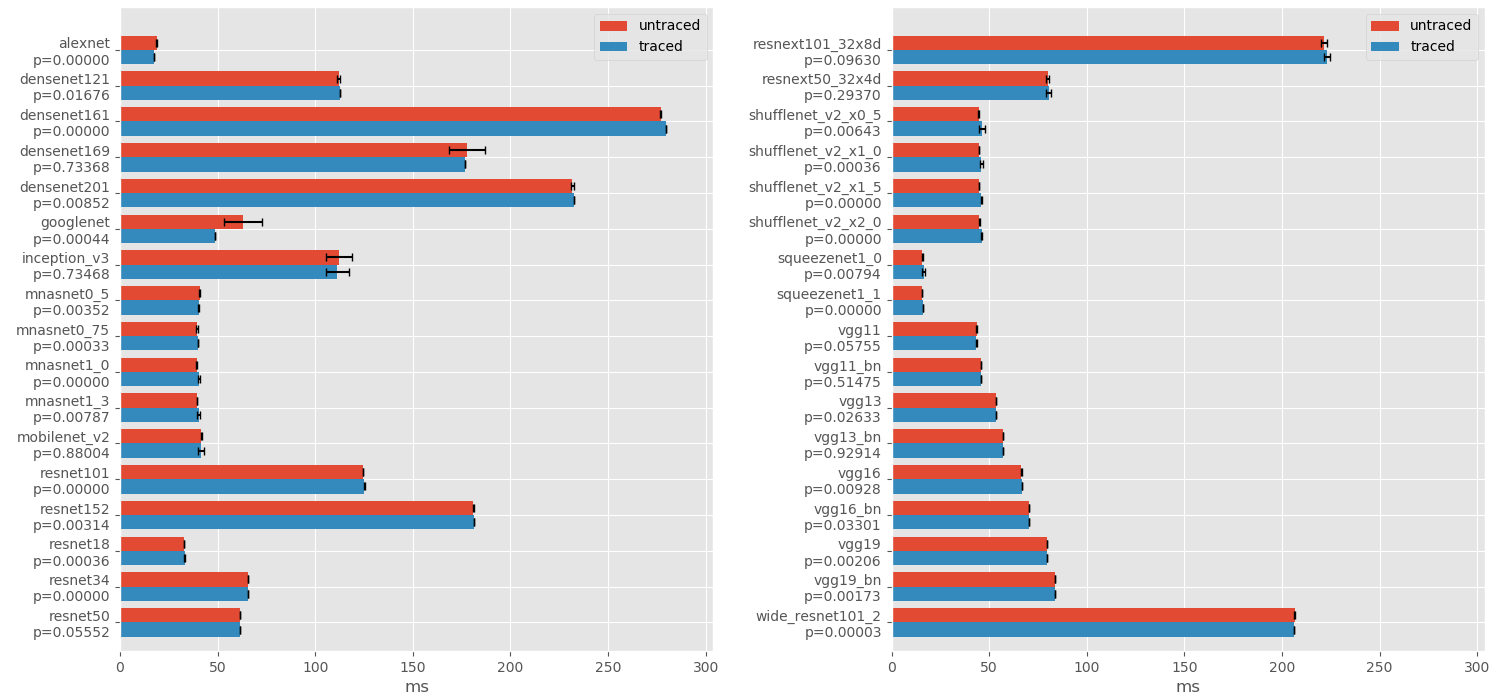

In [22]:
display(Image(filename='./torchvision_plot.png'))